<a href="https://colab.research.google.com/github/pontesjpp/Projeto-Machine-Learning-Quantico/blob/main/ProjetoOficialQuantica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import de bibliotecas**


In [ ]:
%pip install pennylane
import pennylane as qml
from pennylane import numpy as np # Crucial usar o numpy do pennylane para autograd
from pennylane.optimize import NesterovMomentumOptimizer

# Manipulação de Dados
import pandas as pd

# Pré-processamento e Modelagem Clássica (Machine Learning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# from sklearn.impute import SimpleImputer # Se for usar

# Visualização
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 86.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [ ]:
from google.colab import drive #Permite o acesso ao Google drive
drive.mount('/content/drive') #Linkar o caminho do drive


Mounted at /content/drive


In [ ]:
colunas_para_carregar = [
    'IDADEMAE', 'QTDFILVIVO', 'QTDFILMORT', 'SEMAGESTAC',
    'APGAR5', 'APGAR1', 'CONSULTAS', 'SEXO', 'PARTO',
    'STTRABPART', 'GRAVIDEZ', 'PESO','ESCMAE','KOTELCHUCK','MESPRENAT','IDANOMAL','TPAPRESENT'
]

try:
    # Tente carregar apenas as colunas necessárias para economizar memória
    df_original = pd.read_csv('/content/drive/MyDrive/amostra_sinasc.csv', usecols=colunas_para_carregar, nrows=200000, sep=';', encoding='latin1', low_memory=False)
    print(f"Amostra de {len(df_original)} linhas carregada com sucesso.")
except FileNotFoundError:
    print(f"Erro: Arquivo '{'/content/drive/MyDrive/amostra_sinasc.csv'}' não encontrado. Verifique o caminho.")
    exit()
except ValueError as ve:
    print(f"Erro de valor ao carregar colunas: {ve}")
    print("Verifique se todos os nomes em 'colunas_para_carregar' existem no seu CSV.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado ao carregar o CSV: {e}")
    exit()


Amostra de 10000 linhas carregada com sucesso.


# **Análise inicial**

In [ ]:
df_original.head()
print(df_original.dtypes)
df_original.hist(figsize=(12, 12))
plt.suptitle('Histogramas das Colunas')
plt.show()
df_original.describe()

In [ ]:
linha = df_original[(df_original['PESO'] < 500.000000) & (df_original['SEMAGESTAC'] > 36)]
print(linha)

Removi as linhas em que o peso ao nascer era menor que 500 g em gestações completas, tratando esses casos como outliers por não serem compatíveis com a realidade médica.

In [ ]:
indices_para_remover=[150,1662,1682,2099,2296,3934,4480,4920,6594]
df_original = df_original.drop(indices_para_remover)

In [ ]:
df_original.describe()

# **Análise e limpeza de dados**

### 'IDADE MAE'

Os 3 valores ausentes (NaN) na coluna 'IDADEMAE' foram preenchidos com a moda da coluna (24).

In [ ]:
#tratamento da coluna idade mae
quantidade_nans_A = df_original['IDADEMAE'].isna().sum()
print("Quantidade de NaN na coluna 'IDADEMAE':", quantidade_nans_A)
moda = df_original['IDADEMAE'].mode()
print("A moda da coluna é:" , moda[0])
df_original['IDADEMAE']=df_original['IDADEMAE'].fillna(moda[0])
quantidade_nans_A = df_original['IDADEMAE'].isna().sum()
print("Nova Quantidade de NaN na coluna 'IDADEMAE':", quantidade_nans_A)
df_original['IDADEMAE']=df_original['IDADEMAE'].astype(int)


### 'QTDFILVIVO'

Os 531 valores ausentes (5,31%) na coluna 'QTDFILVIVO' foram preenchidos com a moda da coluna, que é 0. A escolha se baseia no fato de que zero é o valor mais frequente e, em questionários, é comum que respostas iguais a zero sejam deixadas em branco, sugerindo que esses valores ausentes podem representar zeros omitidos.

In [ ]:
#tratamento da coluna qtd de filhos vivos
quantidade_nans_B = df_original['QTDFILVIVO'].isna().sum()
print("Quantidade de NaN na coluna 'QTDFILVIVO':", quantidade_nans_B)
moda = df_original['QTDFILVIVO'].mode()
print("A moda da coluna é:" , moda[0])
df_original['QTDFILVIVO']=df_original['QTDFILVIVO'].fillna(moda[0])
quantidade_nans_B = df_original['QTDFILVIVO'].isna().sum()
print("Nova Quantidade de NaN na coluna 'QTDFILVIVO':", quantidade_nans_B)
df_original['QTDFILVIVO']=df_original['QTDFILVIVO'].astype(int)

### 'QTDFILMORT'

Os 746 valores ausentes (NaN) na coluna 'QTDFILMORT' foram preenchidos com a moda da coluna, que é 0. A escolha desse método se justifica pelo mesmo motivo explicado acima na coluna 'QTDFILVIVO'.

In [ ]:
#tratamento da coluna qtd de filhos mortos
quantidade_nans_C = df_original['QTDFILMORT'].isna().sum()
print("Quantidade de NaN na coluna 'QTDFILMORT':", quantidade_nans_C)
moda = df_original['QTDFILMORT'].mode()
print("A moda da coluna é:" , moda[0])
df_original['QTDFILMORT']=df_original['QTDFILMORT'].fillna(moda[0])
quantidade_nans_d = df_original['QTDFILMORT'].isna().sum()
print("Nova Quantidade de Nan na coluna 'QTDFILMORT':",quantidade_nans_d)
df_original['QTDFILMORT']=df_original['QTDFILMORT'].astype(int)

### 'PARTO'

Neste bloco de código, trato os casos em que o tipo de parto foi ignorado (valor 9) e os valores ausentes, substituindo ambos pela moda da coluna. Em seguida, remapeio os valores da coluna, transformando 1 em 0 e 2 em 1, com o objetivo de facilitar a análise.

In [ ]:

a = df_original['PARTO'].value_counts()
print(a)

mapcerto = {1.0: 0, 2.0: 1}
df_original['PARTO'] = df_original['PARTO'].map(mapcerto) #transformo todos '1.0' em 0 e '2.0' em 1, os valores que nao estiverem no dicionário são transformados em NaNs

moda = df_original['PARTO'].mode()
df_original['PARTO'] = df_original['PARTO'].fillna(moda[0]) #preencho todos os NaNs com a moda da coluna
df_original['PARTO']= df_original['PARTO'].astype(int)

b = df_original['PARTO'].value_counts() #verificação da eficácia do método acima
print(b)

### 'CONSULTAS'

Neste bloco de código, trato os casos em que a quantidade de consultas pré-natais foi ignorada (valor 9) e os valores ausentes (NaNs). Os valores ignorados foram substituídos por 1, assumindo que o paciente possivelmente não realizou nenhuma consulta e a resposta foi registrada como ignorada. Já os valores ausentes foram preenchidos com a moda da coluna.

In [ ]:
moda = df_original['CONSULTAS'].mode() #coleto a moda da coluna
print(moda)
df_original['CONSULTAS'] = df_original['CONSULTAS'].replace(9.0,1) #em todos os ignorados, coloco como nenhuma consulta
df_original['CONSULTAS'] = df_original['CONSULTAS'].fillna(moda[0]) #nos NaNs coloco a moda (4)
df_original['CONSULTAS'] = df_original['CONSULTAS'].astype(int)
df_original['CONSULTAS'].value_counts()


### 'SEXO'

Após análise, percebe-se que não há nenhum valor ausente nesta coluna.

In [ ]:
a = df_original['SEXO'].isna().sum()
print(a)
b = df_original['SEXO'].value_counts()
print(b)

### 'APGAR1'

Neste trecho de código, transformo os valores ausentes (233 = 2,33%) com a moda da coluna. O índice APGAR1 avalia a saúde do bebê no primeiro minuto após o nascimento e vai de 0 (grave) a 10 (ótimo) Ele verifica sinais vitais para identificar se o bebê precisa de ajuda imediata.

In [ ]:
nulos = df_original['APGAR1'].isna().sum()
print (nulos)
moda = df_original['APGAR1'].mode()
df_original['APGAR1'] = df_original['APGAR1'].fillna(moda[0])
df_original['APGAR1'] = df_original['APGAR1'].astype(int)


### 'APGAR5'

Repito o mesmo processo acima, porém com o índice APGAR5 que é o índice após 5 minutos de nascimento.

In [ ]:
nulos = df_original['APGAR5'].isna().sum()
print (nulos)
moda = df_original['APGAR5'].mode()
df_original['APGAR5'] = df_original['APGAR5'].fillna(moda[0])
df_original['APGAR5'] = df_original['APGAR5'].astype(int)


### 'SEMAGESTAC'

In [ ]:
nulos = df_original['SEMAGESTAC'].isna().sum()
print (nulos)
moda = df_original['SEMAGESTAC'].mode()
df_original['SEMAGESTAC'] = df_original['SEMAGESTAC'].fillna(moda[0])
df_original['SEMAGESTAC'] = df_original['SEMAGESTAC'].astype(int)

### 'STTRABPART'

In [ ]:
moda = df_original['STTRABPART'].mode()
df_original['STTRABPART'] = df_original['STTRABPART'].replace(9.0,moda[0])
df_original['STTRABPART'] = df_original['STTRABPART'].fillna(moda[0])
df_original['STTRABPART']= df_original['STTRABPART'].astype(int)


### 'ESCMAE'

In [ ]:
null = df_original['ESCMAE'].isna().sum()
print(null)
df_original['ESCMAE'] = df_original['ESCMAE'].replace(9.0,1)
moda = df_original['ESCMAE'].mode()
df_original['ESCMAE'] = df_original['ESCMAE'].fillna(moda[0])
df_original['ESCMAE'] = df_original['ESCMAE'].astype(int)


### 'TPAPRESENT'

In [ ]:
null = df_original['TPAPRESENT'].isna().sum()
print(null)

moda = df_original['TPAPRESENT'].mode()
df_original['TPAPRESENT'] = df_original['TPAPRESENT'].replace(9.0,moda[0])
df_original['TPAPRESENT'] = df_original['TPAPRESENT'].fillna(moda[0])
df_original['TPAPRESENT'] = df_original['TPAPRESENT'].astype(int)
df_original['TPAPRESENT'].value_counts().sum()

### 'ESCMAE'

In [ ]:
null = df_original['ESCMAE'].isna().sum()
print(null)
df_original['ESCMAE'].value_counts()

### 'KOTELCHUCK'

 O Índice de Kotelchuck avalia a adequação do cuidado pré-natal,
considerando o início das consultas e o número de visitas (ajustado pela idade gestacional).


In [ ]:
null = df_original['KOTELCHUCK'].isna().sum()
print(null)
df_original['KOTELCHUCK'].value_counts()

### 'GRAVIDEZ'

Esta coluna indica o número de recém-nascidos por gestação. No tratamento dos dados, os valores ausentes (NaN) e aqueles codificados como 'ignorado' (código 9) foram substituídos pela moda da coluna, que é 1 (indicando parto único).

In [ ]:
null = df_original['GRAVIDEZ'].isna().sum()
print(null)
moda = df_original['GRAVIDEZ'].mode()
df_original['GRAVIDEZ'] = df_original['GRAVIDEZ'].replace(9.0,moda[0])
df_original['GRAVIDEZ'] = df_original['GRAVIDEZ'].fillna(moda[0])
df_original['GRAVIDEZ'] = df_original['GRAVIDEZ'].astype(int)
df_original['GRAVIDEZ'].value_counts()

### 'MESPRENAT'

Neste bloco, a coluna 'MESPRENAT', que indica o mês de início do pré-natal, é tratada: os 300 valores 99.0 (interpretados como 'ignorado') e os 717 NaNs preexistentes foram todos substituídos pela moda da coluna, que é 2 (segundo mês).

In [ ]:
null = df_original['MESPRENAT'].isna().sum()
print(null)
df_original['MESPRENAT'].value_counts()
moda = df_original['MESPRENAT'].mode()
df_original['MESPRENAT'] = df_original['MESPRENAT'].fillna(moda[0])
df_original['MESPRENAT'] = df_original['MESPRENAT'].replace(99.0,moda[0])
df_original['MESPRENAT'] = df_original['MESPRENAT'].astype(int)
df_original['MESPRENAT'].value_counts()

### 'IDANOMAL'

Neste trecho, analiso a coluna 'IDANOMAL', que identifica se alguma anomalia foi observada (1) ou não (2). Nos valores ausentes e ignorados imputei o valor da moda (2). Após isso, transformei os códigos da tabela de (1,2) para (0,1).

In [ ]:
null = df_original['IDANOMAL'].isna().sum()
print(null)
df_original['IDANOMAL'].value_counts()
moda = df_original['IDANOMAL'].mode()
df_original['IDANOMAL'] = df_original['IDANOMAL'].fillna(moda[0])
df_original['IDANOMAL'] = df_original['IDANOMAL'].replace(9.0,moda[0])
map = {1.0: 0, 2.0: 1}
df_original['IDANOMAL'] = df_original['IDANOMAL'].map(map)
df_original['IDANOMAL'] = df_original['IDANOMAL'].astype(int)
df_original['IDANOMAL'].value_counts()

## **Peso**

Como o peso é a variável alvo do meu projeto, optei por remover as linhas com valores ausentes nessa coluna. A imputação de valores poderia introduzir viés e comprometer a confiabilidade dos resultados. Portanto, a exclusão dessas entradas garante maior integridade na análise e no treinamento do modelo.

In [ ]:
nulls = df_original['PESO'].isna().sum()
print (nulls)
df_original = df_original.dropna(subset=['PESO'])
df_original['PESO'] = df_original['PESO'].astype(int)

### Definição da Variável Alvo: Classificação de Peso ao Nascer

Este bloco de código cria a variável alvo para o nosso problema de classificação. O objetivo é categorizar os recém-nascidos com base no seu peso (`PESO` em gramas) em duas classes: Baixo Peso ou Peso Normal.

A nova coluna-alvo (por exemplo, `ALVO_BAIXO_PESO`) é definida da seguinte maneira:
* Recém-nascidos com **Baixo Peso** (peso inferior a 2500 gramas) recebem o rótulo **1**.
* Recém-nascidos com **Peso Normal** (peso igual ou superior a 2500 gramas) recebem o rótulo **-1**.

Essa codificação binária (-1 e 1) é adequada para o treinamento do classificador quântico e para a função de custo que será utilizada.

In [ ]:
# Criar o alvo: 1 para baixo peso, -1 para peso normal
df_original['ALVO_BAIXO_PESO'] = np.where(df_original['PESO'] < 2500, 1, -1)

# Verificar o balanceamento das classes
print("Distribuição da classe:")
print(df_original['ALVO_BAIXO_PESO'].value_counts())

Teste

In [ ]:
#df_original.dtypes
#print((df_original==9).sum())
print(df_original.isna().sum())

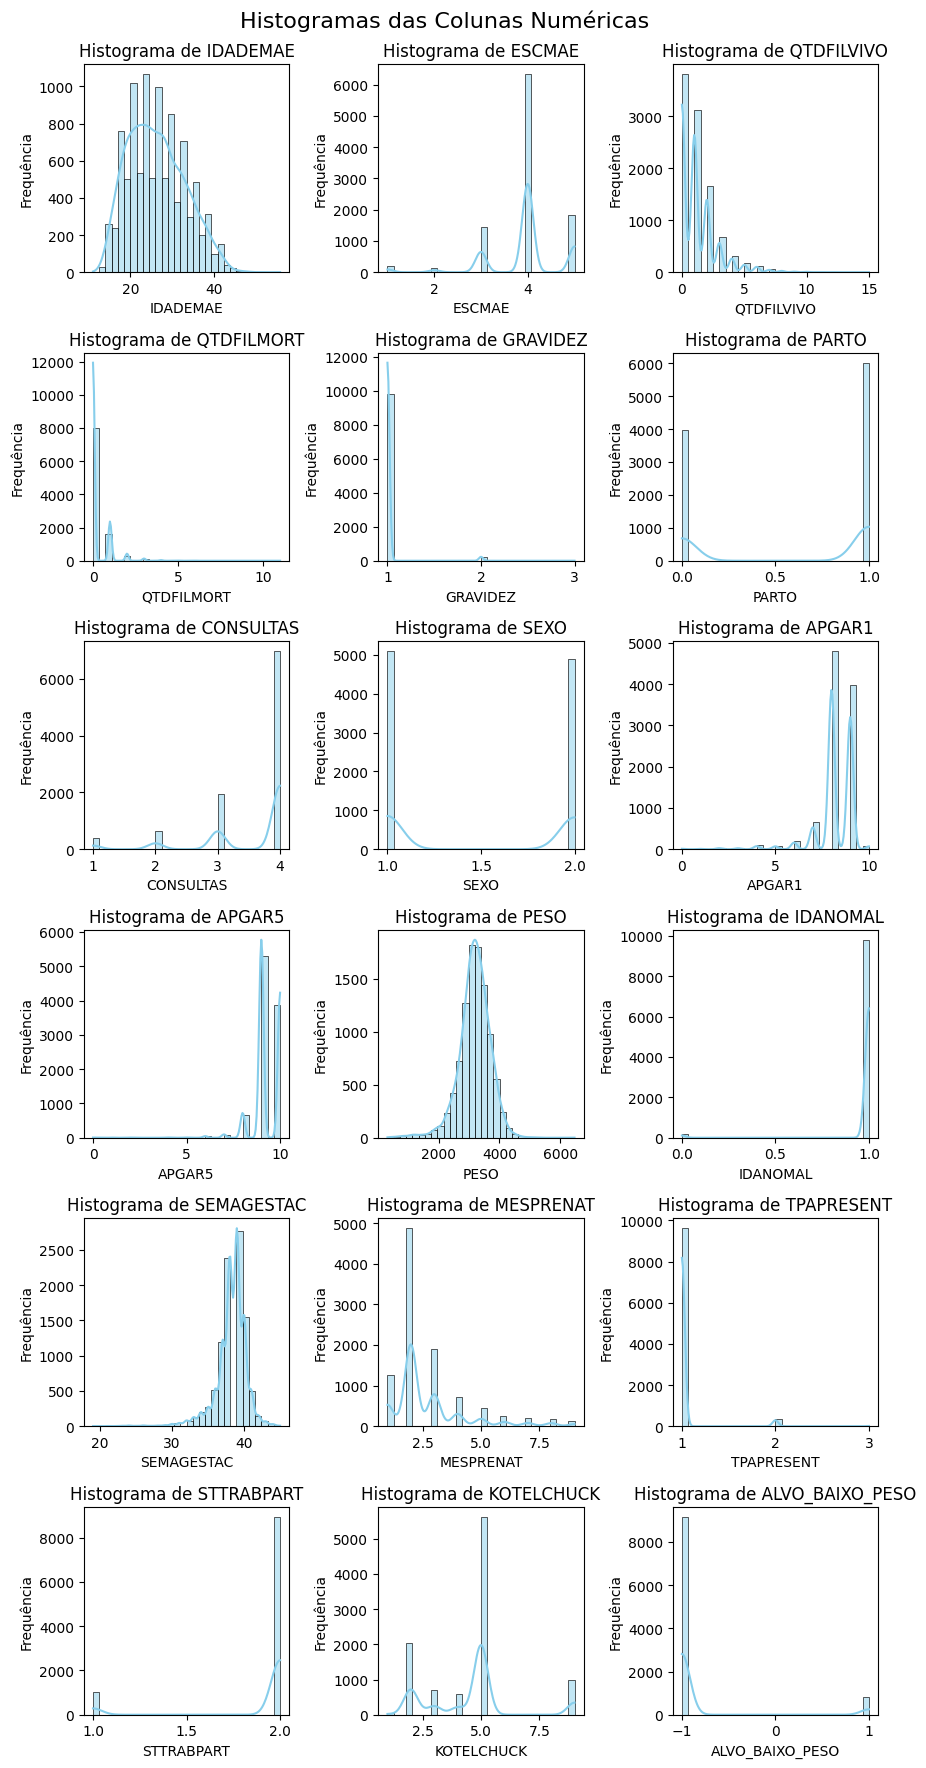

In [ ]:
import seaborn as sns
numeric_cols = df_original.select_dtypes(include='number').columns

# Definindo o tamanho da figura
num_cols = len(numeric_cols)
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(3 * cols_per_row, 3 * rows))

# Criando os histogramas com Seaborn
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_original[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle('Histogramas das Colunas Numéricas', fontsize=16)
plt.show()

#Circuito Quântico Variacional

As features selecionadas são aquelas que exercem a influência mais clara, direta e determinante sobre o comportamento, desempenho ou as saídas do circuito. Outras features poderiam ser redundantes, ter um impacto marginal ou introduzir complexidade desnecessária na análise ou no funcionamento.

In [ ]:
features = [
    'IDADEMAE','SEMAGESTAC',
    'APGAR5','CONSULTAS',
     'GRAVIDEZ','ESCMAE','KOTELCHUCK','MESPRENAT'
]


In [ ]:
qtd_por_classe = 500 # defino a qtd de 500 amostras por classe pra garantir dados balanceados para o treinamento da máquina.
df_baixo_peso = df_original[df_original['ALVO_BAIXO_PESO'] == 1]
df_normal_peso = df_original[df_original['ALVO_BAIXO_PESO'] == -1]
sample_baixo = df_baixo_peso.sample(n=500, random_state=42)
sample_normal = df_normal_peso.sample(n=500, random_state=42)

df_balanceado = pd.concat([sample_baixo, sample_normal]).sample(frac=1, random_state=42) # concateno os df e embaralho a ordem
X_sample = df_balanceado[features].values
Y_sample = df_balanceado['ALVO_BAIXO_PESO'].values

print(f"\nShape dos dados da amostra para QML: X_sample: {X_sample.shape}, Y_sample: {Y_sample.shape}")
print(f"Distribuição da classe na amostra: {pd.Series(Y_sample).value_counts()}")

print(df_balanceado.head(10))


Shape dos dados da amostra para QML: X_sample: (1000, 8), Y_sample: (1000,)
Distribuição da classe na amostra: -1    500
 1    500
Name: count, dtype: int64
      IDADEMAE  ESCMAE  QTDFILVIVO  QTDFILMORT  GRAVIDEZ  PARTO  CONSULTAS  \
9448        22       3           2           2         1      0          1   
6164        14       3           0           0         1      1          1   
82          41       4           7           0         1      0          4   
5577        25       4           0           0         1      1          3   
8364        34       3           0           0         1      1          3   
1391        27       3           5           1         1      0          4   
2361        30       5           2           0         1      1          3   
310         18       4           2           0         1      1          2   
7901        24       4           1           0         1      0          3   
3996        30       4           2           0         1      

In [ ]:
# Divisão em treino e validação
X_train, X_val, Y_train, Y_val = train_test_split(
    X_sample, Y_sample, test_size=0.3, random_state=42, stratify=Y_sample # stratify é bom para classes desbalanceadas
)

print(f"\nShape X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Shape X_val: {X_val.shape}, Y_val: {Y_val.shape}")


### Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
print(f"\nShape X_train_scaled após scaling: {X_train_scaled.shape}")
print(f"Shape X_val_scaled após scaling: {X_val_scaled.shape}")
print(f"Número de features para o QVC: {X_train_scaled.shape[1]}")


### Circuito

In [ ]:
qtd_qubits = 3
qtd_layers = 6
dev = qml.device("default.qubit", wires=3)


In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def layer(W):
    for i in range(qtd_qubits):
        qml.Rot(W[i, 0], W[i, 1], W[i, 2], wires=i)
    for i in range(qtd_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    if qtd_qubits > 1: #CNOT cíclico
        qml.CNOT(wires=[qtd_qubits - 1, 0])

def variational_classifier(weights, bias, x_features):

    return circuit(weights, x_features) + bias

def cost(weights, bias, database, labels):
    predictions = [variational_classifier(weights, bias, x) for x in database]
    return square_loss(labels, predictions)

In [ ]:
from pennylane.templates.layers import StronglyEntanglingLayers

In [ ]:
@qml.qnode(dev, interface="autograd")
def circuit(weights, x_features):

    qml.AmplitudeEmbedding(features=x_features, wires=range(qtd_qubits), normalize=True, pad_with=0.0)

    #StronglyEntanglingLayers(weights, wires=range(qtd_qubits))
    for W_layer_item in weights:
      layer(W_layer_item)

    # Medição no último qubit (pode ser alterado)
    return qml.expval(qml.PauliZ(qtd_qubits - 1))


In [ ]:
from pennylane.optimize import AdamOptimizer

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
np.random.seed(42)

weights_init = 0.1 * np.random.randn(qtd_layers, qtd_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

opt = NesterovMomentumOptimizer(0.05)
batch_size = 32
num_iterations = 200

Y_train_np = np.array(Y_train, requires_grad=False)
Y_val_np = np.array(Y_val, requires_grad=False)

num_train = len(X_train_scaled)

weights = weights_init
bias = bias_init

print("\nIniciando treinamento do classificador quântico")
for it in range(num_iterations):
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = X_train_scaled[batch_index]
    Y_train_batch = Y_train_np[batch_index]

    (weights, bias), cost_val_batch = opt.step_and_cost(
        lambda w, b: cost(w, b, feats_train_batch, Y_train_batch),
        weights, bias
    )

    predictions_train_raw = [variational_classifier(weights, bias, f) for f in X_train_scaled]
    predictions_train_signed = [np.sign(p) if p != 0 else 1 for p in predictions_train_raw]

    predictions_val_raw = [variational_classifier(weights, bias, f) for f in X_val_scaled]
    predictions_val_signed = [np.sign(p) if p != 0 else 1 for p in predictions_val_raw]

    acc_train = accuracy(Y_train_np, predictions_train_signed)
    acc_val = accuracy(Y_val_np, predictions_val_signed)

    precision_val = precision_score(Y_val_np, predictions_val_signed, pos_label=1)
    recall_val = recall_score(Y_val_np, predictions_val_signed, pos_label=1)
    f1_val = f1_score(Y_val_np, predictions_val_signed, pos_label=1)

    current_cost_train = cost(weights, bias, X_train_scaled, Y_train_np)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} | "
        "Precision: {:0.7f} | Recall: {:0.7f} | F1-Score: {:0.7f}"
        .format(it + 1, current_cost_train, acc_train, acc_val, precision_val, recall_val, f1_val)
    )

print("\nTreinamento concluído.")